In [1]:
import torch
import os
from datetime import datetime
import time
import random
import cv2
import pandas as pd
import numpy as np
import albumentations as A
import matplotlib.pyplot as plt
from albumentations.pytorch.transforms import ToTensorV2
from sklearn.model_selection import StratifiedKFold
from torch.utils.data import Dataset,DataLoader
from torch.utils.data.sampler import SequentialSampler, RandomSampler

import pandas as pd
from glob import glob

import json
from pathlib import Path

import scipy
import scipy.io as io
import pickle
from scipy.ndimage.filters import gaussian_filter

from os.path import isfile
from joblib import Parallel, delayed
import psutil

SEED = 42

def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

seed_everything(SEED)

In [2]:
path = '/home/heye0507/drone/drone_benchmark/data/benchmark'
train_images = path + '/images'
test_images = path + '/test_images'
anno = path + '/annotation'
density_maps = path + '/dmaps'

# Run

In [3]:
def gaussian_filter_density(img_shape,points):
    '''
    This code use k-nearst, will take one minute or more to generate a density-map with one thousand people.
    points: a two-dimension list of pedestrians' annotation with the order [[col,row],[col,row],...].
    img_shape: the shape of the image, same as the shape of required density-map. (row,col). Note that can not have channel.
    return:
    density: the density-map we want. Same shape as input image but only has one channel.
    example:
    points: three pedestrians with annotation:[[163,53],[175,64],[189,74]].
    img_shape: (768,1024) 768 is row and 1024 is column.
    '''
    #print("Shape of current image: ",img_shape,". Totally need generate ",len(points),"gaussian kernels.")
    density = np.zeros(img_shape, dtype=np.float32)
    gt_count = len(points)
    if gt_count == 0:
        return density

    leafsize = 2048
    # build kdtree
    tree = scipy.spatial.KDTree(points.copy(), leafsize=leafsize)
    # query kdtree
    distances, locations = tree.query(points, k=4)

    #print ('generate density...')
    for i, pt in enumerate(points):
        pt2d = np.zeros(img_shape, dtype=np.float32)
        if int(pt[1])<img_shape[0] and int(pt[0])<img_shape[1]:
            pt2d[int(pt[1]),int(pt[0])] = 1.
        else:
            continue
        if gt_count > 3:
            sigma = (distances[i][1]+distances[i][2]+distances[i][3])*0.1
        else:
            sigma = 5 #np.average(np.array(gt.shape))/2./2. #case: 1 point
        density += scipy.ndimage.filters.gaussian_filter(pt2d, sigma, mode='constant')
    #print ('done.')
    return density

In [6]:
def expand_path(p):
    fn = p.split('/')[-1].split('.')[0]
    if isfile(train_images + '/' + fn + '.jpg'): 
        return train_images + '/' + fn + '.jpg'
    elif isfile(test_images + '/' + fn + '.jpg'):
        return test_images + '/' + fn + '.jpg'
    return p

def open_image(p):
    image = cv2.imread(p)
    image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB).astype(np.float32)
    image /= 255.
    return image

def get_density_map(p,test=False):
    image_file_p = expand_path(p)
    if image_file_p != p:
        dmap_p = image_file_p.split('/')[-1].split('.')[0]
        dmap_p = density_maps + '/' + dmap_p + '.npy'
        if isfile(dmap_p):
            return
        mat = io.loadmat(p)
        points = mat['annotation'].astype(int)
        image_shape = cv2.imread(image_file_p).shape[:2]
        if test: 
            density_map = None
        else:
            density_map = gaussian_filter_density(image_shape,points)
            #dmap_p = image_file_p.split('/')[-1].split('.')[0]
            #dmap_p = density_maps + '/' + dmap_p + '.npy'
            np.save(dmap_p,density_map)
    else:
        density_map = None
        return p

In [8]:
fns = ['123.txt','456.txt']
with open(path+'/missing.txt','w') as f:
    for fn in fns:
        f.write(fn + '\n')

In [5]:
fns = []
fns.append(Parallel(n_jobs=psutil.cpu_count(),verbose=10)(
    (delayed(get_density_map)(fp) for fp in glob(anno+'/*/*.mat'))
))

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:  3.0min
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:  5.0min
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:  7.6min


KeyboardInterrupt: 

# Test single file

In [3]:
mat = io.loadmat(anno+'/s1/01_001.mat')
mat

{'__header__': b'MATLAB 5.0 MAT-file Platform: nt, Created on: Thu Apr 23 19:02:31 2020',
 '__version__': '1.0',
 '__globals__': [],
 'annotation': array([[ 555.4731336 , 1343.43111468],
        [ 573.92443779, 1365.15603736],
        [ 626.89753694, 1346.70473316],
        [ 556.74665182, 1217.70183471],
        [ 918.70876538, 1060.32176019],
        [ 970.97277673, 1261.2452923 ],
        [1080.66094013, 1122.39441255],
        [1116.25126906, 1012.40782087],
        [1055.83755592,  948.68743063],
        [ 968.47918099,  857.94570408],
        [1108.70915926,  854.78972652],
        [ 969.62349933,  794.56930202],
        [ 988.46609361,  793.26337964],
        [1014.77110148,  788.97249183],
        [1017.00982555,  763.78684601],
        [ 992.94354176,  758.93627718],
        [1113.37642879,  765.58834318],
        [1062.68370999,  733.81859133],
        [1106.95303634,  718.71493882],
        [1040.63584942,  702.91686549],
        [1167.3676464 ,  723.57588445],
        [1058

In [4]:
points = mat['annotation']

In [22]:
def plot_data(img,points=None,fig_size=(18,12)):
    fig, ax = plt.subplots(1, 1, figsize=fig_size)
    if isinstance(points,np.ndarray):
        for point in points.astype(int):
            cv2.circle(img, tuple(point), radius=0,color=(0, 1, 0), thickness=10)
    ax.imshow(img)

In [6]:
image = cv2.imread(train_images+'/01_001.jpg')
image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB).astype(np.float32)
image /= 255.

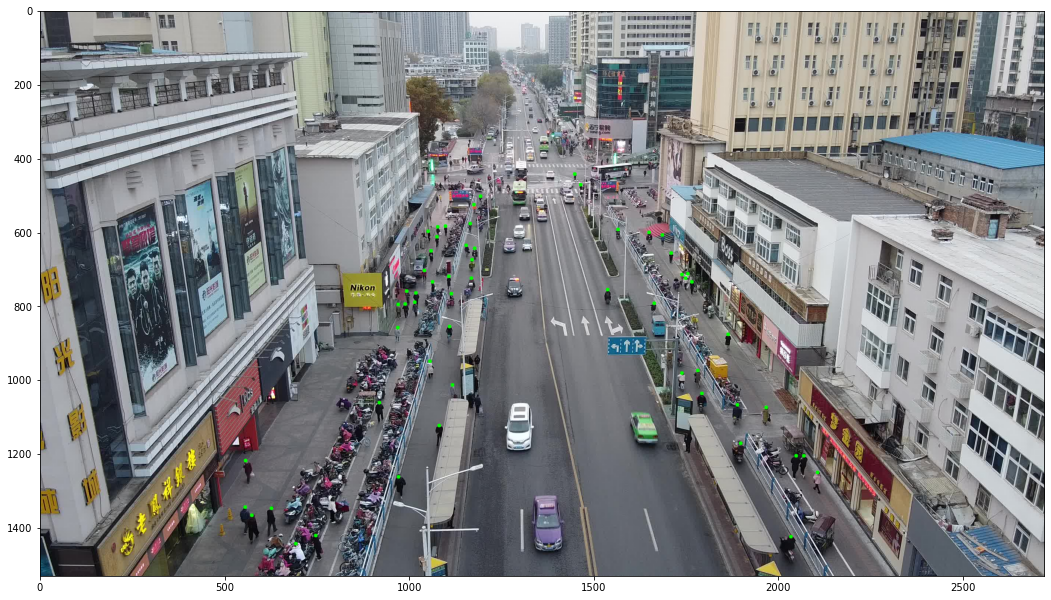

In [7]:
plot_data(image,points)

In [8]:
dot_map = np.zeros(image.shape[:2])

In [9]:
dot_map.shape

(1530, 2720)

In [28]:
%%time
dmap = gaussian_filter_density(dot_map.shape,points.astype(int))

CPU times: user 1min 4s, sys: 19.9 ms, total: 1min 4s
Wall time: 1min 4s


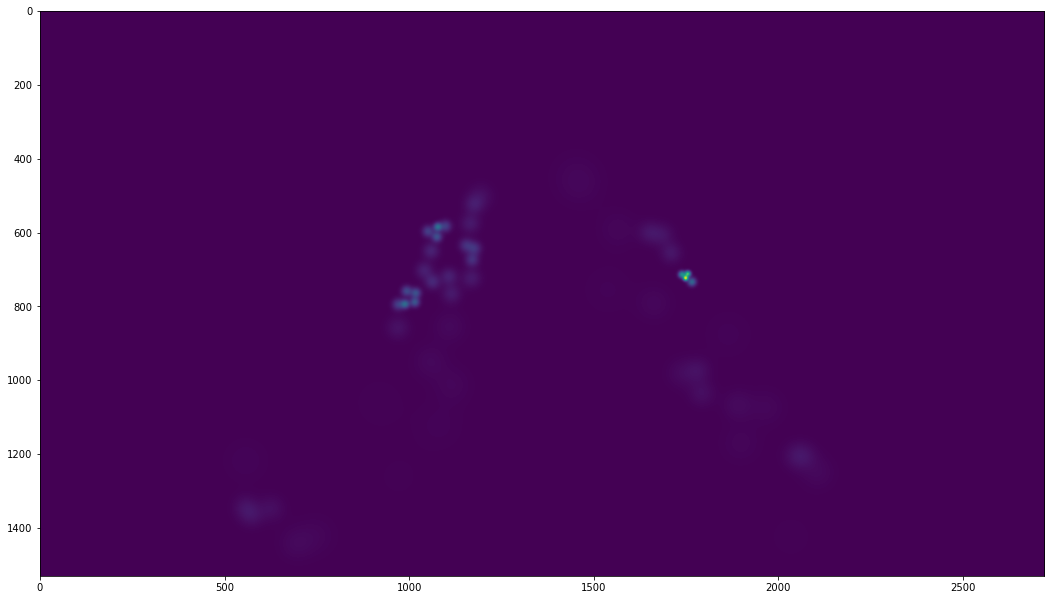

In [27]:
plot_data(dmap)

# Test Parallel

In [16]:
from os.path import isfile
from joblib import Parallel, delayed
import psutil

In [31]:
len(glob(anno+'/*/*.mat'))

9818

In [32]:
len(glob(train_images+'/*.jpg'))

6300

In [33]:
len(glob(test_images+'/*.jpg'))

2700

In [9]:
t_file = glob(anno+'/*/*.mat')[100]
t_file

'/home/heye0507/drone/drone_benchmark/data/benchmark/annotation/s4/04_371.mat'

In [44]:
%%time
p = get_density_map(t_file)

CPU times: user 58.5 s, sys: 44 ms, total: 58.5 s
Wall time: 58.6 s


In [34]:
p = Parallel(n_jobs=psutil.cpu_count(),verbose=10)(
    (delayed(get_density_map)(fp) for fp in glob(anno+'/*/*.mat'))
)

[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  10 out of  10 | elapsed:  9.1min finished


In [35]:
%%time
for fp in glob(anno+'/*/*.mat')[:10]:
    get_density_map(fp)

CPU times: user 14min 12s, sys: 352 ms, total: 14min 12s
Wall time: 14min 13s


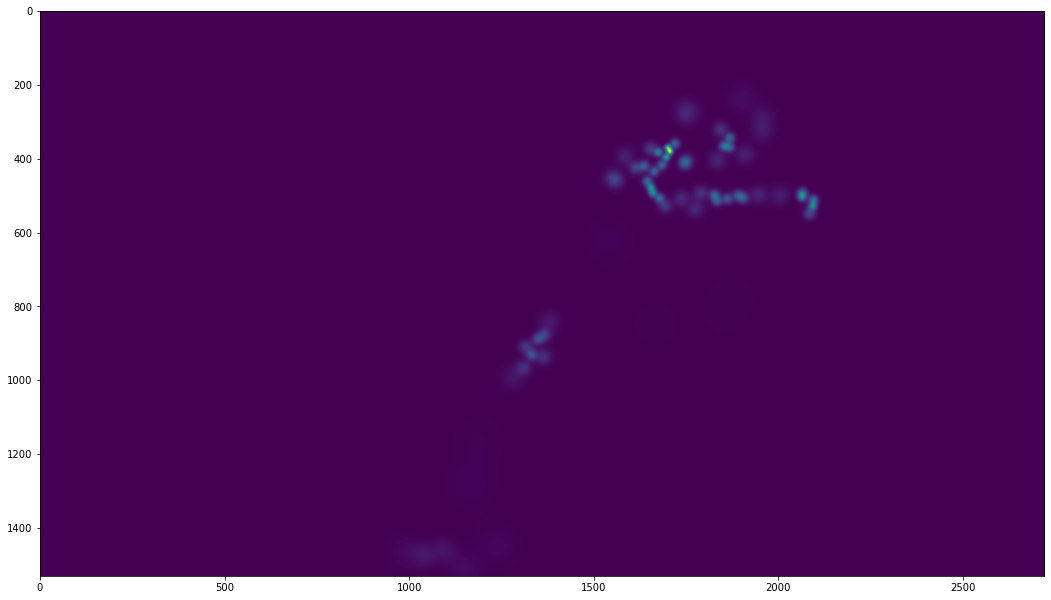

In [32]:
plot_data(np.load(density_maps+'/04_371.pkl',allow_pickle=True))

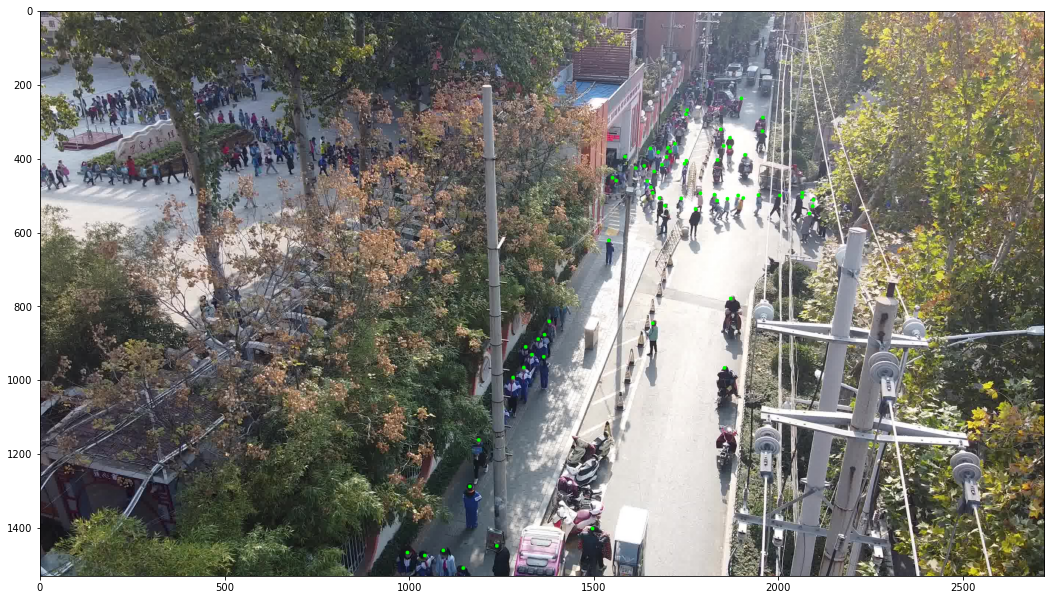

In [23]:
plot_data(open_image(fn),points)

In [45]:
dmap = np.load(density_maps+'/04_371.npy')

In [46]:
dmap.shape

(1530, 2720)

In [40]:
np.save(density_maps+'/04_371.npy',dmap)